# Ujian Tengah Semester

## Prio Budi Laksono

## 210411100177

## 1. Scraping Data dari Artikel

In [8]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import string
import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download('stopwords')

def scraping_artikel(url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        title = soup.find('h1').get_text().strip()
        date = soup.find('time').get_text().strip()
        content = soup.find_all('p')
        teks_artikel = '\n'.join([p.get_text().strip() for p in content if p.get_text().strip()])
        
        return {'Judul': title, 'Tanggal': date, 'Konten': teks_artikel}
    else:
        print(f"Gagal mengambil artikel. Status code: {response.status_code}")
        return None

url = 'https://www.idntimes.com/sport/soccer/sandy-firdaus/kalah-dari-china-pssi-yakin-indonesia-masih-bisa-bersaing'
data_artikel = scraping_artikel(url)

data_df = pd.DataFrame([data_artikel]) if data_artikel else pd.DataFrame()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pblak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pblak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Preprocessing Data

In [9]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words = set(stopwords.words('indonesian'))

def preproses_teks(teks):
    # Mengubah teks menjadi huruf kecil
    teks = teks.lower()
    
    # Menghapus tanda baca, angka, karakter non-ASCII misalnya, é, ñ, ü, dan spasi ganda
    teks = re.sub(f"[{string.punctuation}]", '', teks)
    teks = re.sub(r'\d+', '', teks)
    teks = re.sub(r'[^\x00-\x7F]+', '', teks)
    teks = re.sub(r'\s+', ' ', teks)
    
    # Tokenisasi teks (mengubah teks menjadi perkata)
    token = word_tokenize(teks)
    
    # Menghapus stopword (saya,kamu,dia)
    token = [kata for kata in token if kata not in stop_words]
    
    # Stemming kata-kata (mengubah berjalan menjadi jalan)
    token = [stemmer.stem(kata) for kata in token]
    
    return token

# Terapkan preprocessing pada kolom 'Konten'
data_df['Token'] = data_df['Konten'].apply(preproses_teks)

## 3. Menghitung TF IDF

In [10]:
# Menggabungkan semua teks untuk TF-IDF
all_text = data_df['Konten'].tolist()

# Ambil stop words dari NLTK dan simpan dalam list
stop_words_list = list(stop_words)

tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words_list)
tfidf_matrix = tfidf_vectorizer.fit_transform(all_text)

# Membuat DataFrame dari TF-IDF
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Mencetak hasil TF-IDF untuk seluruh artikel
print("\nTF-IDF untuk Seluruh Artikel:")
print(tfidf_df)


TF-IDF untuk Seluruh Artikel:
         10        12        15        16      2024      2026       afc  \
0  0.043478  0.043478  0.043478  0.043478  0.043478  0.086957  0.043478   

    anggota       app      arab  ...  tergeser  tertahan    thohir       tim  \
0  0.043478  0.043478  0.086957  ...  0.043478  0.043478  0.043478  0.043478   

      times    timnas     tirai    tunggu    unggul        vs  
0  0.043478  0.173913  0.043478  0.043478  0.043478  0.043478  

[1 rows x 107 columns]


C:\Users\pblak\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


## 4. Analisis Frequency

In [11]:
# Langkah 4: Analisis Frekuensi
semua_token = [token for tokens in data_df['Token'] for token in tokens]
frekuensi_kata = Counter(semua_token)
top_10_kata = frekuensi_kata.most_common(10)

print("10 Kata Teratas:", top_10_kata)

# Mempersiapkan untuk Matriks Co-occurrence (menghitung seberapa sering dua kata muncul bersama dalam suatu konteks,)
top_kata = [kata for kata, freq in top_10_kata]
co_occurrence = pd.DataFrame(0, index=top_kata, columns=top_kata)

for tokens in data_df['Token']:
    tokens_top = [token for token in tokens if token in top_kata]
    for i in range(len(tokens_top)):
        for j in range(i + 1, len(tokens_top)):
            kata1 = tokens_top[i]
            kata2 = tokens_top[j]
            co_occurrence.at[kata1, kata2] += 1
            co_occurrence.at[kata2, kata1] += 1

print("Matriks Co-occurrence:")
print(co_occurrence)

10 Kata Teratas: [('arya', 8), ('indonesia', 7), ('china', 7), ('laga', 7), ('pssi', 5), ('lawan', 5), ('bahrain', 5), ('timnas', 4), ('kalah', 4), ('sisa', 4)]
Matriks Co-occurrence:
           arya  indonesia  china  laga  pssi  lawan  bahrain  timnas  kalah  \
arya         56         56     56    56    40     40       40      32     32   
indonesia    56         42     49    49    35     35       35      28     28   
china        56         49     42    49    35     35       35      28     28   
laga         56         49     49    42    35     35       35      28     28   
pssi         40         35     35    35    20     25       25      20     20   
lawan        40         35     35    35    25     20       25      20     20   
bahrain      40         35     35    35    25     25       20      20     20   
timnas       32         28     28    28    20     20       20      12     16   
kalah        32         28     28    28    20     20       20      16     12   
sisa         32 

## 5. Matriks Cosine Similarity

In [12]:
cosine_sim_matrix = cosine_similarity(co_occurrence) #mengukur kesamaan antara dua vektor
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=top_kata, columns=top_kata) #Nilai tersebut biasanya berada dalam rentang 0 hingga 1, di mana 1 berarti sangat mirip dan 0 berarti tidak ada kesamaan.

print("\nMatriks Cosine Similarity:")
print(cosine_sim_df)


Matriks Cosine Similarity:
               arya  indonesia     china      laga      pssi     lawan  \
arya       1.000000   0.996880  0.996880  0.996880  0.996938  0.996938   
indonesia  0.996880   1.000000  0.996885  0.996885  0.996923  0.996923   
china      0.996880   0.996885  1.000000  0.996885  0.996923  0.996923   
laga       0.996880   0.996885  0.996885  1.000000  0.996923  0.996923   
pssi       0.996938   0.996923  0.996923  0.996923  1.000000  0.996923   
lawan      0.996938   0.996923  0.996923  0.996923  0.996923  1.000000   
bahrain    0.996938   0.996923  0.996923  0.996923  0.996923  0.996923   
timnas     0.996980   0.996956  0.996956  0.996956  0.996937  0.996937   
kalah      0.996980   0.996956  0.996956  0.996956  0.996937  0.996937   
sisa       0.996980   0.996956  0.996956  0.996956  0.996937  0.996937   

            bahrain    timnas     kalah      sisa  
arya       0.996938  0.996980  0.996980  0.996980  
indonesia  0.996923  0.996956  0.996956  0.996956  
c

## 6. Membuat Graf


Degree Centrality:
           Degree Centrality
arya                     1.0
indonesia                1.0
china                    1.0
laga                     1.0
pssi                     1.0
lawan                    1.0
bahrain                  1.0
timnas                   1.0
kalah                    1.0
sisa                     1.0
Jumlah Node: 10
Jumlah Edge: 45


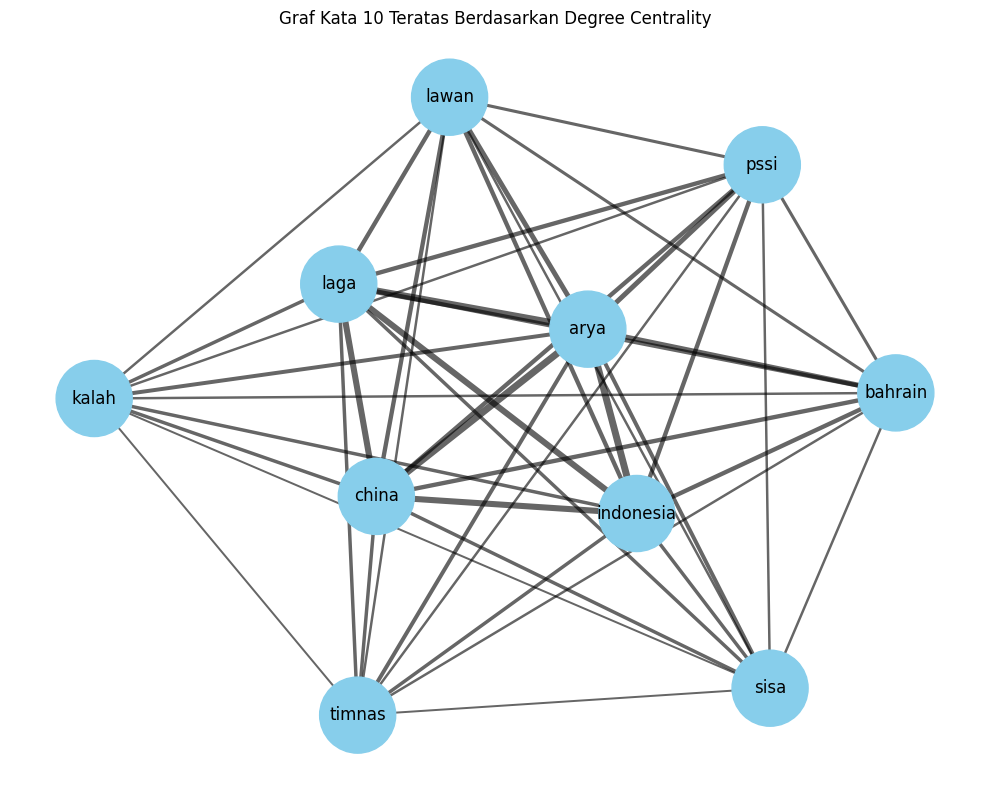

In [13]:
# Menghitung hanya Degree Centrality
degree_centrality = nx.degree_centrality(G)

# Menampilkan Degree Centrality
centrality_df = pd.DataFrame({
    'Degree Centrality': degree_centrality
}).sort_values(by='Degree Centrality', ascending=False)

print("\nDegree Centrality:")
print(centrality_df)

# Mencetak jumlah node dan edge dalam graf
jumlah_node = G.number_of_nodes()
jumlah_edge = G.number_of_edges()

print(f"Jumlah Node: {jumlah_node}")
print(f"Jumlah Edge: {jumlah_edge}")

# Visualisasi graf
plt.figure(figsize=(10, 8))

# Menggunakan layout spring
pos = nx.spring_layout(G, k=0.5, seed=42)

# Menggambar node dengan ukuran berdasarkan degree centrality
node_size = [v * 3000 for v in degree_centrality.values()]
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='skyblue')

# Menggambar edge dengan ketebalan berdasarkan weight
edges = G.edges(data=True)
edge_width = [d['weight'] * 5 for (u, v, d) in edges]
nx.draw_networkx_edges(G, pos, width=edge_width, alpha=0.6)

# Menggambar label
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

plt.title("Graf Kata 10 Teratas Berdasarkan Degree Centrality")
plt.axis('off')
plt.tight_layout()
plt.show()